In [1]:
# # CNN FINETUNING WITH PRE-TRAINED VGG NET - Small Training Size
%matplotlib inline
import os
import numpy as np
import tensorflow as tf
import load_fmri_multich_dottest_transferlearning as input_data
import matplotlib.pyplot as plt
import scipy.misc
import scipy.io
#from tensorflow.examples.tutorials.mnist import input_data

# Load Data
fmri = input_data.read_data_sets("../data/AllSubjects4cat.hdf5", fraction=1, channels=3)
trainimg   = fmri.train.images
trainlabel = fmri.train.labels
testimg    = fmri.test.images
testlabel  = fmri.test.labels
ntrain      = trainimg.shape[0]
ntest       = testimg.shape[0]
dim         = trainimg.shape[1]
nout        = trainlabel.shape[1]

print ("%d train images loaded" % (ntrain))
print ("%d test images loaded" % (ntest))
print ("%d dimensional input" % (dim))
# print ("%d classes" % (nclass))
print ("shape of 'trainimg' is %s" % (trainimg.shape,))
print ("shape of 'testimg' is %s" % (testimg.shape,))

print (trainlabel.shape)

Loading Training Imagery...
............................
Loading Test Imagery...
..........279 train images loaded
94 test images loaded
9000 dimensional input
shape of 'trainimg' is (279, 9000)
shape of 'testimg' is (94, 9000)
(279, 2)


In [2]:
img = np.reshape(testimg[90],(50,60,3) )
np.max(img[:,:,2])

1.0

(-0.5, 59.5, 49.5, -0.5)

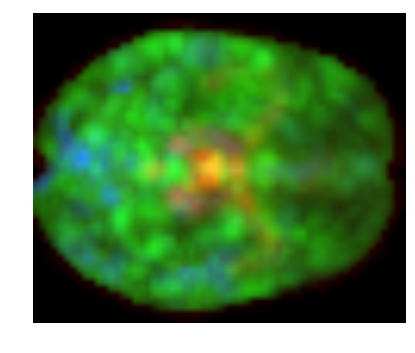

In [38]:
img = np.reshape(testimg[27],(50,60,3) )
plt.imshow(img[:,:,:])
plt.axis("off")

In [6]:
trainimg_tensor = np.ndarray((ntrain, 50, 60, 3))
for i in range(ntrain):
    currimg = trainimg[i, :]
    currimg = np.reshape(currimg, [50, 60, 3])
    trainimg_tensor[i, :, :, :] = currimg
print ("shape of trainimg_tensor is %s" % (trainimg_tensor.shape,))

testimg_tensor = np.ndarray((ntest, 50, 60, 3))
for i in range(ntest):
    currimg = testimg[i, :]
    currimg = np.reshape(currimg, [50, 60, 3])
    testimg_tensor[i, :, :, :] = currimg
print ("shape of testimg_tensor is %s" % (testimg_tensor.shape,))

shape of trainimg_tensor is (279, 50, 60, 3)
shape of testimg_tensor is (94, 50, 60, 3)


In [7]:

# # DEFINE A FUNCTION FOR USING PRETRAINED VGG NETWORK

def net(data_path, input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',
        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )
    data = scipy.io.loadmat(data_path)
    mean = data['normalization'][0][0][0]
    mean_pixel = np.mean(mean, axis=(0, 1))
    weights = data['layers'][0]
    net = {}
    current = input_image
    for i, name in enumerate(layers):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            current = _conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = _pool_layer(current)
        net[name] = current

    assert len(net) == len(layers)
    return net, mean_pixel
with tf.device("/cpu:0"):
    def _conv_layer(input, weights, bias):
        conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
                            padding='SAME')
        return tf.nn.bias_add(conv, bias)

    def _pool_layer(input):
        return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
                              padding='SAME')

    def preprocess(image, mean_pixel):
        return image - mean_pixel

    def unprocess(image, mean_pixel):
        return image + mean_pixel

In [8]:
## EXTRACT FEATURES FROM THE VGG NETWORK
cwd = os.getcwd()
VGG_PATH = cwd + "/data/imagenet-vgg-verydeep-19.mat"
with tf.Graph().as_default(), tf.Session() as sess:
    with tf.device("/cpu:0"):
        img_placeholder = tf.placeholder(tf.float32, shape=(None, 50, 60, 3))
        net_val, mean_pixel = net(VGG_PATH, img_placeholder)
        train_features = net_val['relu5_4'].eval(feed_dict={img_placeholder: trainimg_tensor})
        print("Train Features finished...")
        test_features = net_val['relu5_4'].eval(feed_dict={img_placeholder: testimg_tensor})
print ("TYPE OF 'train_features' IS %s" % (type(train_features)))
print ("SHAPE OF 'train_features' IS %s" % (train_features.shape,))
print ("TYPE OF 'test_features' IS %s" % (type(test_features)))
print ("SHAPE OF 'test_features' IS %s" % (test_features.shape,))
print("PREPROCESSING DONE")

Train Features finished...
TYPE OF 'train_features' IS <type 'numpy.ndarray'>
SHAPE OF 'train_features' IS (279, 4, 4, 512)
TYPE OF 'test_features' IS <type 'numpy.ndarray'>
SHAPE OF 'test_features' IS (94, 4, 4, 512)
PREPROCESSING DONE


In [9]:
# # VECTORIZE CNN FEATURES

train_vectorized = np.ndarray((ntrain, 8192))
test_vectorized = np.ndarray((ntest, 8192))
for i in range(ntrain):
    curr_feat = train_features[i, :, :, :]
    curr_feat_vec = np.reshape(curr_feat, (1, -1))
    train_vectorized[i, :] = curr_feat_vec

for i in range(ntest):
    curr_feat = test_features[i, :, :, :]
    curr_feat_vec = np.reshape(curr_feat, (1, -1))
    test_vectorized[i, :] = curr_feat_vec

print ("SHAPE OF 'train_vectorized' IS %s" % (train_vectorized.shape,))
print ("SHAPE OF 'test_vectorized' IS %s" % (test_vectorized.shape,))

# # DEFINE NETWORKS AND FUNCTIONS (ADD 2LAYER MLP)

SHAPE OF 'train_vectorized' IS (279, 8192)
SHAPE OF 'test_vectorized' IS (94, 8192)


In [30]:
# Parameters
learning_rate = 0.00001  # default 0.0001
training_epochs = 300
batch_size = 10  # default 100
display_step = 3

In [31]:
# Network
with tf.device("/cpu:0"):
    n_input = dim
    n_output = 2
    # n_output = nclass
    weights = {
        'wd1': tf.Variable(tf.random_normal([8192, 1024], stddev=0.1)),
        'wd2': tf.Variable(tf.random_normal([1024, n_output], stddev=0.1))
    }
    biases = {
        'bd1': tf.Variable(tf.random_normal([1024], stddev=0.1)),
        'bd2': tf.Variable(tf.random_normal([n_output], stddev=0.1))
    }


    def conv_basic(_input, _w, _b, _keepratio):
        # Input
        _input_r = _input
        # Vectorize
        _dense1 = tf.reshape(_input_r, [-1, _w['wd1'].get_shape().as_list()[0]])
        # Fc1
        _fc1 = tf.nn.relu(tf.add(tf.matmul(_dense1, _w['wd1']), _b['bd1']))
        _fc_dr1 = tf.nn.dropout(_fc1, _keepratio)
        # Fc2
        _out = tf.add(tf.matmul(_fc_dr1, _w['wd2']), _b['bd2'])
        # Return everything
        out = {'input_r': _input_r, 'dense1': _dense1,
               'fc1': _fc1, 'fc_dr1': _fc_dr1, 'out': _out}
        return out

# tf Graph input
x = tf.placeholder(tf.float32, [None, 8192])
y = tf.placeholder(tf.float32, [None, n_output])
keepratio = tf.placeholder(tf.float32)


In [32]:
# Functions!
with tf.device("/cpu:0"):
    _pred = conv_basic(x, weights, biases, keepratio)['out']
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(_pred, y))
    optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    _corr = tf.equal(tf.argmax(_pred, 1), tf.argmax(y, 1))  # Count corrects
    accr = tf.reduce_mean(tf.cast(_corr, tf.float32))  # Accuracy
    init = tf.initialize_all_variables()

print ("Network Ready to Go!")

Network Ready to Go!


In [33]:
testing = []
training = []

with tf.device("/cpu:0"):
    sess = tf.Session()
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        num_batch = int(ntrain / batch_size) + 1
        # Loop over all batches
        for i in range(num_batch):
            randidx = np.random.randint(ntrain, size=batch_size)
            batch_xs = train_vectorized[randidx, :]
            batch_ys = trainlabel[randidx, :]
            # Fit training using batch data
            sess.run(optm, feed_dict={x: batch_xs, y: batch_ys, keepratio: 0.7})
            # Compute average loss
            avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, keepratio: 1.}) / num_batch

        # Display logs per epoch step
        if epoch % display_step == 0:
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
            train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys, keepratio: 1.})
            print (" Training accuracy: %.3f" % (train_acc))
            training.append(train_acc)
            test_acc = sess.run(accr, feed_dict={x: test_vectorized, y: testlabel, keepratio: 1.})
            print (" Test accuracy: %.3f" % (test_acc))
            testing.append(test_acc)

print ("Optimization Finished!")

Epoch: 000/300 cost: 1.243473639
 Training accuracy: 0.700
 Test accuracy: 0.436
Epoch: 003/300 cost: 1.058848530
 Training accuracy: 0.300
 Test accuracy: 0.436
Epoch: 006/300 cost: 1.021499051
 Training accuracy: 0.600
 Test accuracy: 0.447
Epoch: 009/300 cost: 0.916937130
 Training accuracy: 0.500
 Test accuracy: 0.479
Epoch: 012/300 cost: 0.901729533
 Training accuracy: 0.400
 Test accuracy: 0.447
Epoch: 015/300 cost: 0.684874498
 Training accuracy: 0.500
 Test accuracy: 0.447
Epoch: 018/300 cost: 0.697979268
 Training accuracy: 0.700
 Test accuracy: 0.457
Epoch: 021/300 cost: 0.743365195
 Training accuracy: 0.700
 Test accuracy: 0.457
Epoch: 024/300 cost: 0.825485249
 Training accuracy: 0.900
 Test accuracy: 0.500
Epoch: 027/300 cost: 0.708570777
 Training accuracy: 0.600
 Test accuracy: 0.489
Epoch: 030/300 cost: 0.739754967
 Training accuracy: 0.500
 Test accuracy: 0.500
Epoch: 033/300 cost: 0.674337272
 Training accuracy: 0.500
 Test accuracy: 0.468
Epoch: 036/300 cost: 0.67782

In [34]:
#Let's plot training and testing acurracy across 300 epochs
print(len(testing))
x = [ i*display_step for i in range(0,len(testing))]

100


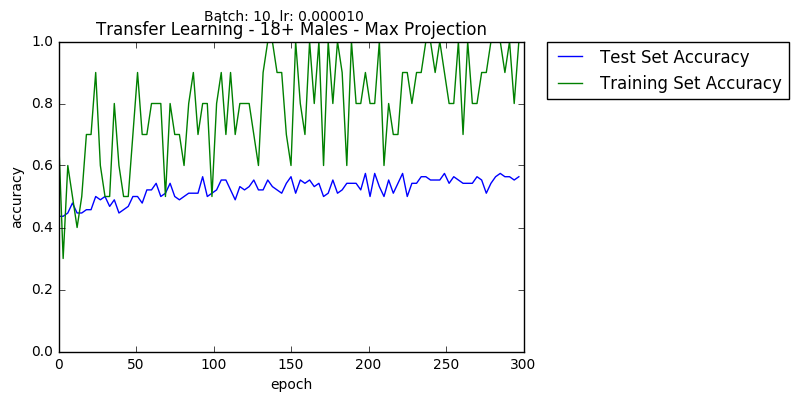

In [37]:
#Let's plot training and testing acurracy across 300 epochs
#print(len(testing))
x = [ i*display_step for i in range(0,len(testing))]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(x, testing, label="Test Set Accuracy")
ax1.plot(x,training, label="Training Set Accuracy")
ax1.set_ylim([0.,1.])
ax1.set_xlabel("epoch")
ax1.set_ylabel("accuracy")
ax1.set_title("Transfer Learning - 18+ Males - Max Projection")

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)

fig.suptitle("Batch: %d, lr: %f" % (batch_size, learning_rate) )